In [1]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra, Diffusity

┌ Info: Precompiling Diffusity [fca15081-c8d4-4aca-bcfd-1103cbe75c6b]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{\rm eq}(x)$

In [3]:
sigma_kref = 8.
kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

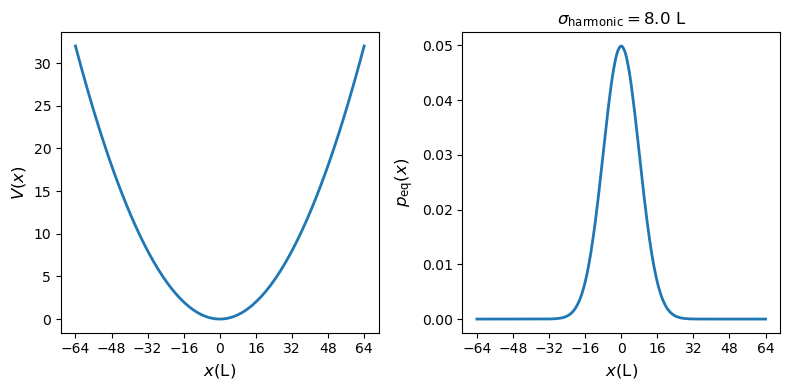

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
#ax.set_ylim(0, 10)

ax = axes[2]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
ax.set_title(@sprintf "\$\\sigma_{\\rm harmonic} = %.1f\$ L" sigma_kref)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/harmonic_well_r.svg")
plt.show()

### Part 3: Set parameters about simulations

In [4]:
# physical parameters
save_freq = 1e-2 # unit: s, Save trajectory per 1e-2 s
total_times = 100 # unit: s, totol simulate 100 s
dt = 2e-5 # unit: s  # Integration Times 1ps
D = 500; # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [5]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_r_0.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

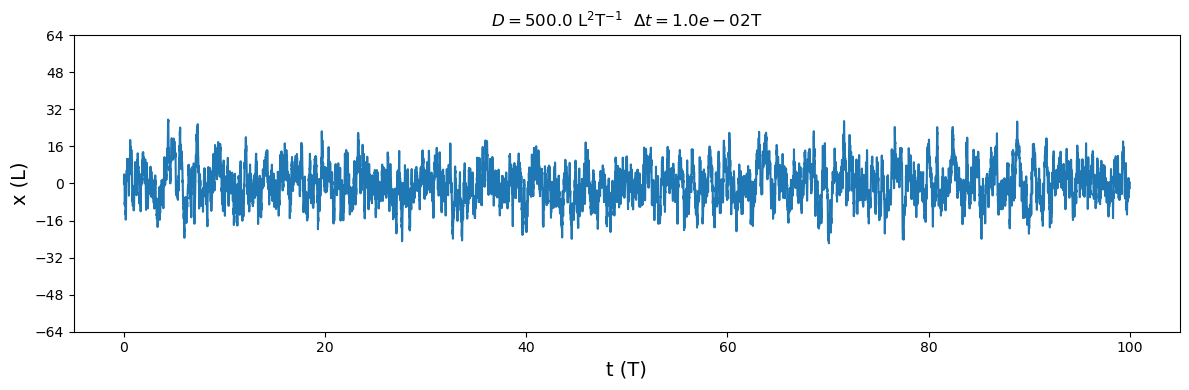

In [9]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record, y_record)
ax.set_ylabel("x (L)", fontsize=lbfz)
ax.set_xlabel("t (T)", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f\$ L\$^{2}\$T\$^{-1}\$  \$\\Delta t=%.1e\$T " D save_freq)
ax.set_yticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/reduced_traj.svg")
plt.show()

### Part 4: FEM to get eigenvector and eigenvalues when $D=1$

In [6]:
D_unity = 1e0
eigenvalues_prime, eigenvect_mat_prime, rho_eq_by_fem_prime = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, p_eq, D_unity, Nv)
weight_Qx_prime = get_weight_Qx(N, Nv, w0, eigenvect_mat_prime);

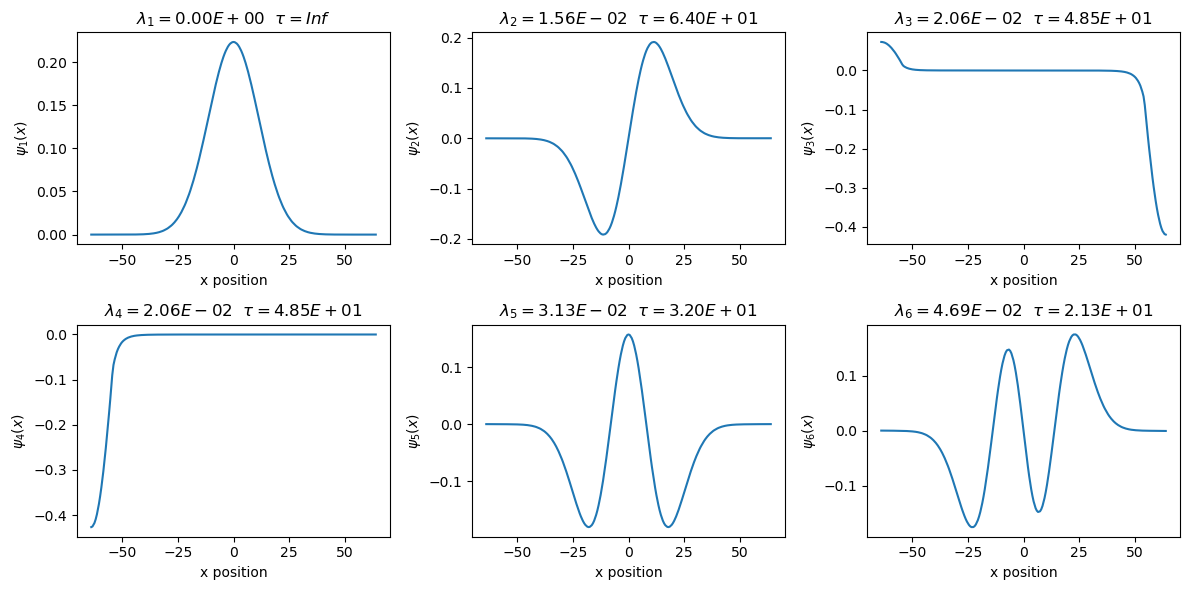

In [46]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12,6))

idx_eigvector = 1
for row_id = 1:2
    for col_id = 1:3
        plot_x_Qx_lambda(axes[row_id, col_id], idx_eigvector, eigenvalues, eigenvect_mat, xref)
        idx_eigvector += 1
        #axes[row_id, col_id].set_ylim(-0.4, 0.4)
    end
end

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/distance_dependent_D.pdf")
plt.show()

### Part 5: Set Photon $\sigma$

In [7]:
σ_delta = 2.0
k_delta = get_k_by_sigma(σ_delta);

### Part 6: Set $D_{\text{guess}}$

In [8]:
D_guess = 500;

### Part 7: Forward Backward

In [9]:
alpha_mat, beta_mat, Anorm_vec, r_sqrt_array = Diffusity.forward_backward_v0(Nv, tau, w0, p_eq, N, eigenvect_mat_prime, y_record, 
    xref, e_norm, interpo_xs, Np, k_delta, D_guess, eigenvalues_prime, save_freq);

### Part 8: Check $\sum \hat{\alpha}(\textbf{s}_n) =1$

In [50]:
store_array = zeros(tau)
for time_idx = 1:tau
    store_array[time_idx] = sum(alpha_mat[:,time_idx] .^ 2)
end

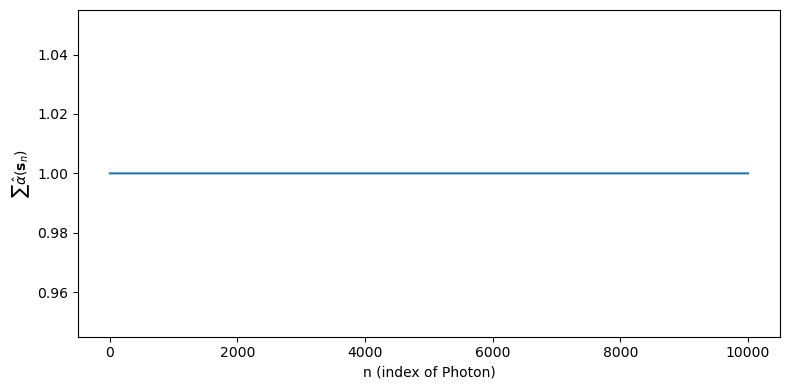

In [54]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4))

xarray = 1:tau
ax.plot(xarray, store_array)
ax.set_ylabel("\$\\sum \\hat{\\alpha}(\\mathbf{s}_n)\$")
ax.set_xlabel("n (index of Photon)")

plt.tight_layout()
plt.show()

### Part 9: $\gamma(\textbf{x}_n)$ and $\gamma(\textbf{s}_n)$

In [13]:
store_array = zeros(tau)
for time_idx = 1:tau
    gamma_x, gamma_s = Diffusity.get_gamma(N, Nv, w0, alpha_mat, beta_mat, time_idx, eigenvect_mat_prime)
    store_array[time_idx] = sum(gamma_x .* w0)
end

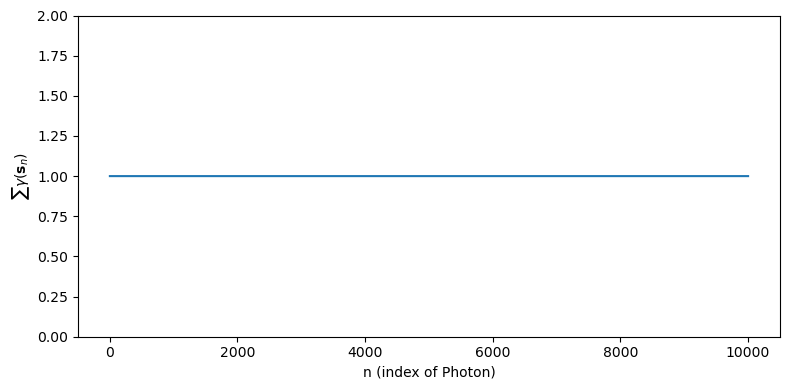

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4))

xarray = 1:tau
ax.plot(xarray, store_array)
ax.set_ylabel("\$\\sum \\gamma(\\mathbf{s}_n)\$")
ax.set_xlabel("n (index of Photon)")
ax.set_ylim(0,2)

plt.tight_layout()
plt.show()

In [10]:
# Selete time index
time_idx_sele = 4;

In [11]:
gamma_x, gamma_s = Diffusity.get_gamma(N, Nv, w0, alpha_mat, beta_mat, time_idx_sele, eigenvect_mat_prime);

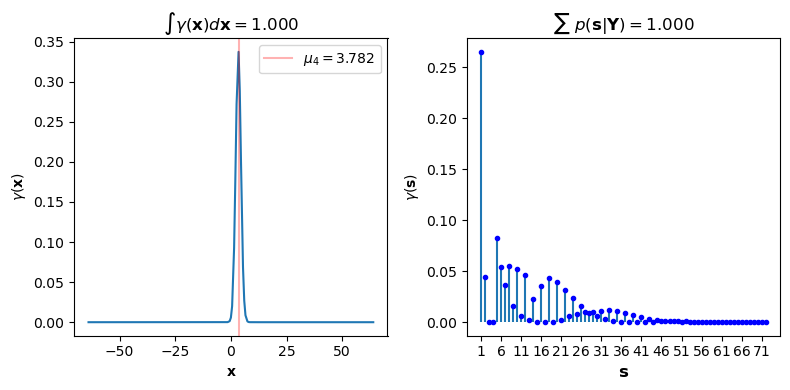

In [12]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, gamma_x)
label = @sprintf "\$ \\mu_{%d}=%.3f\$" time_idx_sele y_record[time_idx_sele]
ax.axvline(y_record[time_idx_sele], color="red", label=label, alpha=0.3)
ax.set_ylabel("\$\\gamma(\\mathbf{x})\$")
ax.set_xlabel("\$\\mathbf{x}\$")
title = @sprintf "\$ \\int \\gamma(\\mathbf{x}) d\\mathbf{x}=%.3f \$" sum(gamma_x .* w0)
ax.set_title(title)
ax.legend()

ax = axes[2]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, gamma_s, "b.")
ax.vlines(xarray, ymin=0, ymax=gamma_s)
ax.set_xlabel("\$\\mathbf{s}\$", fontsize=12)
ax.set_ylabel("\$\\gamma(\\mathbf{s})\$")
ax.set_xticks(xticks)
title = @sprintf "\$\\sum~p(\\mathbf{s}|\\mathbf{Y})=%.3f \$" sum(gamma_s)
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/beta4_example.pdf")
plt.show()

### Part 10: $\xi(\textbf{s}_{n-1}, \textbf{s}_{n})$
\begin{equation}
    \xi(\textbf{s}_{4},\textbf{s}_{5}) = \frac{\left( \textbf{y}_5 | \hat{\beta}_5 \left>\right<\hat{\alpha}_4 |e^{-\textbf{H}\Delta t}\right)^2}{c_5}
\end{equation}

In [18]:
expLQDT = exp.(-(D_guess * eigenvalues_prime) .* save_freq);

In [50]:
time_idx = 5
photon_mat = get_photon_matrix_gaussian(y_record[time_idx], xref, e_norm, interpo_xs, Np, w0, k_delta)
psi_photon_psi = eigenvect_mat_prime' * photon_mat * eigenvect_mat_prime

# Photon operation
y_beta_hat_next = psi_photon_psi * beta_mat[:,time_idx]
y_beta_hat_next = y_beta_hat_next ./ norm(y_beta_hat_next) # Note, normalization

alpha_hat_edt = expLQDT .* alpha_mat[:,time_idx-1]
alpha_hat_edt[1] = sign(alpha_hat_edt[1]) * sqrt(1 - sum((alpha_hat_edt[2:end]).^2));

In [51]:
ket_vector = zeros((Nv,1))
bra_vector = zeros((1,Nv))
ket_vector[:,1] = y_beta_hat_next
bra_vector[1,:] = alpha_hat_edt
xi_s4_s5 = ((ket_vector * bra_vector) .^ 2)

72×72 Array{Float64,2}:
 0.232963    0.012995     4.32405e-9   …  9.10304e-20  1.71242e-20
 0.00113385  6.32473e-5   2.10454e-11     4.43051e-22  8.33444e-23
 3.86673e-9  2.15691e-10  7.17708e-17     1.51093e-27  2.84228e-28
 2.50038e-9  1.39474e-10  4.64098e-17     9.77024e-28  1.83793e-28
 0.104165    0.00581047   1.93342e-9      4.07027e-20  7.65677e-21
 0.00153197  8.5455e-5    2.8435e-11   …  5.98617e-22  1.12609e-22
 0.0698652   0.00389717   1.29678e-9      2.72999e-20  5.13551e-21
 0.00172531  9.62397e-5   3.20236e-11     6.74165e-22  1.2682e-22
 0.0521007   0.00290624   9.67047e-10     2.03584e-20  3.82971e-21
 0.00181693  0.000101351  3.37243e-11     7.09969e-22  1.33556e-22
 0.0408185   0.0022769    7.57637e-10  …  1.59499e-20  3.0004e-21
 0.00180704  0.000100799  3.35407e-11     7.06102e-22  1.32828e-22
 0.0281528   0.0015704    5.22547e-10     1.10007e-20  2.0694e-21
 ⋮                                     ⋱  ⋮            
 2.82754e-5  1.57723e-6   5.24822e-13  …  1.10486e-2

In [54]:
norm(psi_photon_psi * beta_mat[:,time_idx])

0.2492156409301657

In [57]:
sqrt.(r_sqrt_array[1:6])

6-element Array{Float64,1}:
 0.25656264819657654
 0.2532762216249504
 0.257945964527544
 0.25581866341530746
 0.28976199194445806
 0.29204106283925796